In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, RandomSampler, TensorDataset
import time
import torch.nn as nn

In [2]:
def make_2d_classification(N=4000):
    a_pos1 = torch.randn(N//4, 2) + torch.tensor([3.0, 2.0])
    a_pos2 = torch.randn(N//4, 2) + torch.tensor([-3.0, 3.0])
    a_neg = torch.randn(N//2, 2) + torch.tensor([-2.0, -10.0])
    data = torch.cat([a_pos1, a_pos2, a_neg], dim=0)
    data = (data - data.mean(axis=0)) / np.sqrt(data.var(axis=0))
    labels = torch.cat([torch.ones(N//2), torch.zeros(N//2)])
    return TensorDataset(data, labels)

In [3]:
# cifar_classes = ('plane', 'car', 'bird', 'cat',
#            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [4]:
# from https://docs.pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

import torchvision
import torchvision.transforms as transforms

# transform = transforms.Compose(
    # [transforms.ToTensor(),
    #  transforms.Normalize((0.5,), (0.5,))])

trainset = torchvision.datasets.MNIST(root='./data', 
                                      train=True,
                                      download=True, 
                                      #transform=transform
                                      )

testset = torchvision.datasets.MNIST(root='./data', 
                                     train=False,
                                     download=True,
                                     #transform=transform
                                     )

In [5]:
from torch.utils.data import TensorDataset
from sklearn.preprocessing import StandardScaler

def filter_classes_MNIST(dataset, classes_to_keep):

    # Get data and targets
    data = dataset.data.flatten(start_dim=1)
    targets = dataset.targets

    # Create mask
    mask = (targets == classes_to_keep[0]) | (targets == classes_to_keep[1])

    # Apply mask
    # filtered_data = (data[mask] / 255).float()
    
    scaler = StandardScaler()
    filtered_data = torch.from_numpy(scaler.fit_transform(data[mask])).float()

    # filtered_data = (filtered_data - filtered_data.mean(axis=0)) / np.sqrt(filtered_data.var(axis=0))

    label_map = {classes_to_keep[0]: 0, classes_to_keep[1]: 1}
    filtered_targets = torch.tensor([label_map[t.item()] for t in targets[mask]])

    return TensorDataset(filtered_data, filtered_targets)

In [6]:
mnist_01_train = filter_classes_MNIST(trainset, [0,1])
# mnist_01_test = filter_classes_MNIST(testset, [0,1])

In [7]:
def show_images(images, labels):
    fig, axes = plt.subplots(1, len(images), figsize=(10, 2))
    for img, label, ax in zip(images, labels, axes):
        ax.imshow(img.squeeze(), cmap='gray')
        ax.set_title(f'Label: {label}')
        ax.axis('off')
    plt.show()

In [8]:
# check https://shaoanlu.wordpress.com/2017/05/29/sgd-all-which-one-is-the-best-optimizer-dogs-vs-cats-toy-experiment/
# check https://github.com/shaoanlu/dogs-vs-cats-redux/blob/master/opt_experiment.ipynb

In [9]:
from sklearn.datasets import make_blobs

# torch.manual_seed(42)
# np.random.seed(42)

DATASET_SIZE = 1000
DATASET_DIM = 20
DATASET_CLUSTER_COUNT = 5

def blob_dataset():
    clustered_data, _ = make_blobs(n_samples=DATASET_SIZE, 
                                n_features=DATASET_DIM,
                                centers=DATASET_CLUSTER_COUNT,
                                #random_state=42
                                )

    data = torch.from_numpy(clustered_data.astype(np.float32))
    labels = torch.zeros(DATASET_SIZE)
    return TensorDataset(data, labels)

In [10]:
from cluster_tools import kmeans_elbow, ClusterSampler, logistic_label_01_process

Samplers

In [11]:
from torch import nn

LAMBDA = 1e-4 # L2 regularization

class SimpleModel(nn.Module):
    def __init__(self, dataset):
        super().__init__()
        assert len(dataset.shape) == 2, "Do not use with images"
        dim = dataset.shape[1]
        self.layer = nn.Linear(dim, 1, bias=True)
        self.layer.weight.data.fill_(0)
        self.layer.bias.data.fill_(0)
    
    def forward(self, ai):
        return self.layer(ai)

def log_01_criterion(pred, labels):
    l = labels.view(-1, 1)*2 - 1
    return (nn.functional.softplus(-l*pred)).mean()

In [12]:
dataset = mnist_01_train #make_2d_classification()
clustered_data, full_labels = dataset.tensors
labeled_data = logistic_label_01_process(dataset)

In [13]:
# probably utils function
from utils import dimension_reduction

compressed_data = dimension_reduction(clustered_data, alg="pca")

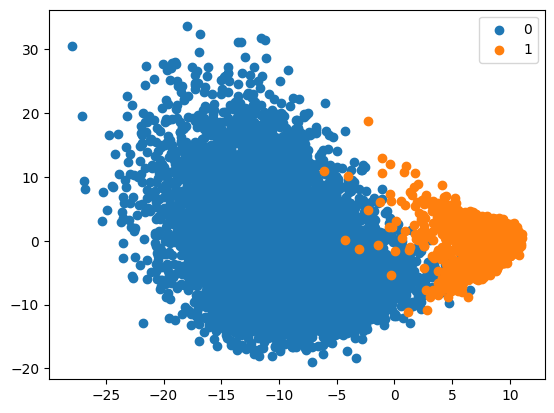

In [14]:
compressed_labeled = dimension_reduction(labeled_data, alg="pca")
mask_0 = (full_labels == 0)
mask_1 = (full_labels == 1)
plt.scatter(compressed_data[mask_0,0], compressed_data[mask_0,1], label="0")
plt.scatter(compressed_data[mask_1,0], compressed_data[mask_1,1], label="1")
plt.legend()
plt.show()

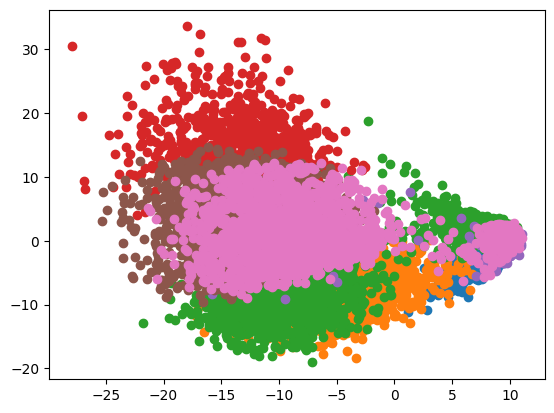

In [15]:
cluster_sampler = ClusterSampler(dataset, 64, label_processing=logistic_label_01_process)
for i in range(cluster_sampler.cluster_count):
    selected = compressed_data[cluster_sampler.clusters[i]]
    plt.scatter(selected[:,0], selected[:,1])
# plt.scatter(labeled_data[mask_0,0], labeled_data[mask_0,1], color="white", alpha=0.1)
plt.show()

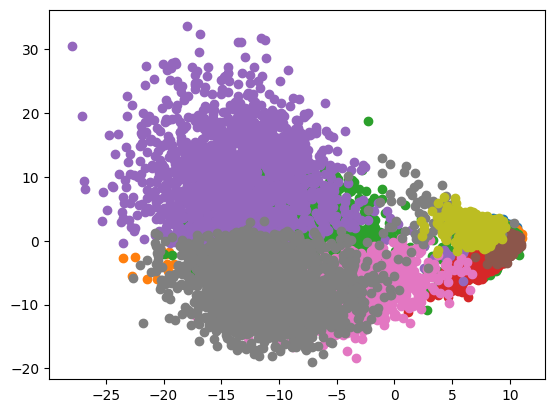

In [16]:
from cluster_tools import kmeans_cos_elbow

cosine_cluster_sampler = ClusterSampler(dataset, 64, clustering_method=kmeans_cos_elbow, label_processing=logistic_label_01_process)
for i in range(cosine_cluster_sampler.cluster_count):
    selected = compressed_data[cosine_cluster_sampler.clusters[i]]
    plt.scatter(selected[:,0], selected[:,1])
# plt.scatter(compressed_data[mask_0,0], compressed_data[mask_0,1], color="white", alpha=0.1)
plt.show()

Solvers

In [17]:
def get_grad(batch, labels, model):
    ret = np.zeros_like(batch)
    for i, (elem, lab) in enumerate(zip(batch, labels)):
        res = model(elem)
        l = log_01_criterion(res, lab)
        model.zero_grad()
        l.backward()
        ret[i] = (next(model.parameters()).grad.data.detach().numpy().squeeze())
    return ret

In [18]:
# finding an exact solution

from tqdm import tqdm
from solvers import get_regularized_loss

model = SimpleModel(clustered_data)

curr_epoch = 0
regularized_ls = []
lr = 2

while 1:
    reg_loss = get_regularized_loss(model, 
                                    clustered_data, 
                                    full_labels, 
                                    log_01_criterion,
                                    LAMBDA)
    model.zero_grad()
    reg_loss.backward()
    for p in model.parameters():
        p.data.sub_(lr*(p.grad.data)) #+ LAMBDA*p.data))
    regularized_ls.append(reg_loss.item())
    curr_epoch += 1
    if curr_epoch % 1000 == 0:
        print(curr_epoch, reg_loss.item())
    if curr_epoch > 1 and regularized_ls[-2] - regularized_ls[-1] < 1e-12:
        break

opt_val = regularized_ls[-1]
print(curr_epoch, opt_val)

1000 0.0025750466156750917
2000 0.0017532818019390106
3000 0.0012413491494953632
4000 0.0009141056216321886
5000 0.0007190221222117543
6000 0.0006169333937577903
7000 0.0005713013233616948
8000 0.0005531322676688433
9000 0.0005457170773297548
10000 0.0005423208931460977
11000 0.0005405955598689616
12000 0.0005396606284193695
13000 0.0005391343147493899
14000 0.0005388305289670825
14891 0.000538667431101203


In [19]:
output = model(clustered_data)
model.zero_grad()
loss = log_01_criterion(output, full_labels)
loss.backward()
for p in model.parameters():
    print(lr*(p.grad.data + LAMBDA*p.data))

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  6.9654e-08,
          6.9654e-08,  6.9654e-08,  2.3632e-09, -7.5290e-09, -9.8842e-08,
         -1.0393e-07,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00, -1.1874e-07,
         -1.1874e-07,  0.0000e+00,  3.0447e-08, -1.1468e-07, -1.2050e-07,
          0.0000e+00,  5.5835e-08,  8.

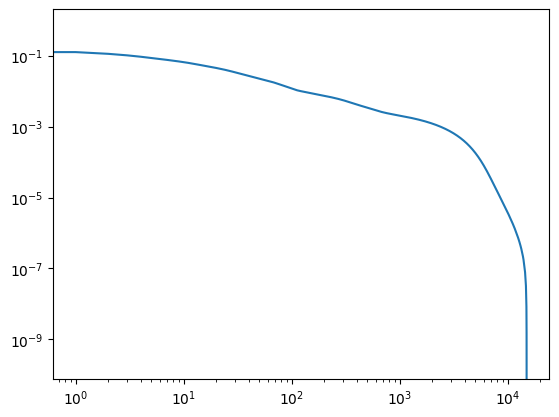

In [20]:
plt.plot(np.array(regularized_ls)-opt_val)
# plt.yscale("log")
plt.loglog()
plt.show()

In [21]:
from solvers import solve_problem, svrg, COVER, clusterSVRG

In [22]:
from utils import clone_model

In [23]:
NB_EPOCH = 200
TIME_LIM = None # 25
BATCH_SIZE = 64

REPEAT_TIMES = 10

In [24]:
base_model = SimpleModel(clustered_data)
lr = 2
lr_one_t = lambda epoch: 5 / (epoch+1)
lr_log_t = lambda epoch: 5 * np.log(epoch+1) / (epoch+1)

In [25]:
cluster_dataloader = DataLoader(dataset, BATCH_SIZE, sampler=cluster_sampler)
cosine_dataloader = DataLoader(dataset, BATCH_SIZE, sampler=cosine_cluster_sampler)

iid_sampler = RandomSampler(dataset, replacement=True)
iid_dataloader = DataLoader(dataset, BATCH_SIZE, sampler=iid_sampler)

In [ ]:
svrg_time, svrg_sol, _ = svrg(clone_model(base_model, clustered_data),
                regress_criterion,
                DataLoader(dataset, BATCH_SIZE, shuffle=True),
                clustered_data,
                n_epoch=NB_EPOCH,
                time_lim=TIME_LIM,
                learning_rate=lr,
                lr_lambda=lr_log_t)

In [ ]:
cover_time, cover_sol, _ = COVER(clone_model(base_model, clustered_data),
                     regress_criterion,
                     dataset,
                     RandomSampler(dataset),
                     clustered_data,
                     n_epoch=None,
                     time_lim=TIME_LIM,
                     learning_rate=lr,
                     lr_lambda=lr_log_t)

In [ ]:
clusterSVRG_time, clusterSVRG_sol, _ = clusterSVRG(clone_model(base_model, clustered_data),
                     regress_criterion,
                     dataset,
                     RandomSampler(dataset),
                     clustered_data,
                     n_epoch=None,
                     time_lim=TIME_LIM,
                     learning_rate=lr,
                     lr_lambda=lr_log_t)

  0%|          | 3/100000 [00:34<320:36:28, 11.54s/it]


In [ ]:
grad_des_time, grad_des_sol, _ = solve_problem(
    clone_model(base_model, clustered_data), 
    regress_criterion,
    optimizer_class=torch.optim.SGD,
    dataloader=DataLoader(dataset, len(clustered_data)),
    n_epoch=NB_EPOCH,
    time_lim=TIME_LIM,
    verbose=True,
    lr=lr,
    # lr_lambda=lr_log_t,
    )

Building models...


  0%|          | 158/100000 [00:30<5:18:07,  5.23it/s]


In [ ]:
svrg_single_time, svrg_single_sol, _ = svrg(clone_model(base_model, clustered_data),
                regress_criterion,
                DataLoader(dataset, shuffle=True),
                clustered_data,
                n_epoch=NB_EPOCH,
                time_lim=TIME_LIM,
                learning_rate=lr,
                lr_lambda=lr_log_t)

  0%|          | 3/100000 [00:39<363:39:27, 13.09s/it]


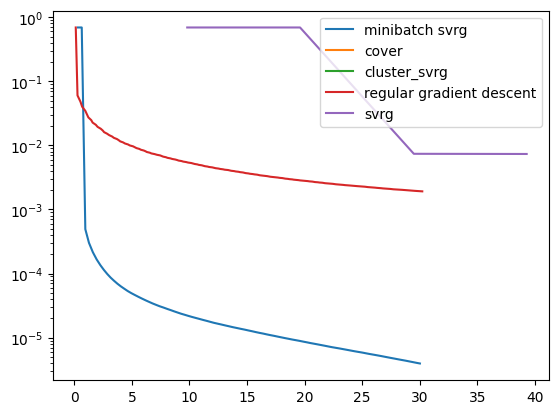

In [ ]:
plt.plot(svrg_time, svrg_sol-opt_val, label="minibatch svrg")
plt.plot(cover_time, cover_sol-opt_val, label="cover")
plt.plot(clusterSVRG_time, clusterSVRG_sol-opt_val, label="cluster_svrg")
plt.plot(grad_des_time, grad_des_sol-opt_val, label="regular gradient descent")
plt.plot(svrg_single_time, svrg_single_sol-opt_val, label="svrg")
plt.yscale("log")
plt.legend()
plt.show()

In [26]:
def repeat_exec(base_model,
                model_arg,
                criterion,
                optimizer_class,
                dataloader,
                n_epoch=NB_EPOCH,
                time_lim=TIME_LIM,
                verbose=True,
                repeat_times=REPEAT_TIMES,
                lr=lr,
                lr_lambda=lr_one_t,
                l2=LAMBDA):
    timestamps, sols = [], []
    for i in range(repeat_times):
        sgd_time, sgd_sol, _ = solve_problem(
            clone_model(base_model, model_arg), 
            criterion,
            optimizer_class,
            dataloader,
            n_epoch,
            time_lim,
            verbose,
            lr,
            lr_lambda,
            l2)
        timestamps.append(sgd_time)
        sols.append(sgd_sol)
    return timestamps, sols

In [27]:
sgd_times, sgd_sols = repeat_exec(
    base_model, clustered_data, 
    log_01_criterion,
    optimizer_class=torch.optim.SGD,
    dataloader=DataLoader(dataset, BATCH_SIZE, shuffle=True),
)

Building models...


100%|██████████| 200/200 [00:44<00:00,  4.50it/s]


Building models...


100%|██████████| 200/200 [00:44<00:00,  4.54it/s]


Building models...


100%|██████████| 200/200 [00:43<00:00,  4.55it/s]


Building models...


100%|██████████| 200/200 [00:43<00:00,  4.55it/s]


Building models...


100%|██████████| 200/200 [00:43<00:00,  4.56it/s]


Building models...


100%|██████████| 200/200 [00:44<00:00,  4.54it/s]


Building models...


100%|██████████| 200/200 [00:45<00:00,  4.44it/s]


Building models...


100%|██████████| 200/200 [00:45<00:00,  4.40it/s]


Building models...


100%|██████████| 200/200 [00:45<00:00,  4.40it/s]


Building models...


100%|██████████| 200/200 [00:45<00:00,  4.39it/s]


In [ ]:
adam_time, adam_sol, _ = solve_problem(clone_model(base_model, clustered_data), 
              regress_criterion,
              optimizer_class=torch.optim.Adam,
              dataloader=DataLoader(dataset, BATCH_SIZE, shuffle=True),
              n_epoch=NB_EPOCH,
              time_lim=TIME_LIM,
              verbose=True,
              lr=lr,
              lr_lambda=lr_log_t)

Building models...


  0%|          | 92/100000 [00:25<7:34:03,  3.67it/s]


In [ ]:
plt.plot(sgd_time, sgd_sol-opt_val, label="sgd")
plt.plot(adam_time, adam_sol-opt_val, label="adam")
plt.plot(svrg_time, svrg_sol-opt_val, label="svrg")
plt.plot(grad_des_time, grad_des_sol-opt_val, label="regular gradient descent")
plt.xlabel("time (s)")
plt.legend()
plt.yscale("log")
plt.show()

In [28]:
sgd_iid_times, sgd_sols_iid = repeat_exec(
    base_model, clustered_data, 
    log_01_criterion,
    optimizer_class=torch.optim.SGD,
    dataloader=iid_dataloader,
)

Building models...


100%|██████████| 200/200 [00:46<00:00,  4.34it/s]


Building models...


100%|██████████| 200/200 [00:45<00:00,  4.44it/s]


Building models...


100%|██████████| 200/200 [00:44<00:00,  4.46it/s]


Building models...


100%|██████████| 200/200 [00:44<00:00,  4.45it/s]


Building models...


100%|██████████| 200/200 [00:44<00:00,  4.47it/s]


Building models...


100%|██████████| 200/200 [00:45<00:00,  4.44it/s]


Building models...


100%|██████████| 200/200 [00:45<00:00,  4.44it/s]


Building models...


100%|██████████| 200/200 [00:44<00:00,  4.46it/s]


Building models...


100%|██████████| 200/200 [00:44<00:00,  4.45it/s]


Building models...


100%|██████████| 200/200 [00:44<00:00,  4.48it/s]


In [29]:
sgd_cluster_times, sgd_sols_cluster = repeat_exec(
    base_model, clustered_data, 
    log_01_criterion,
    optimizer_class=torch.optim.SGD,
    dataloader=cluster_dataloader,
)

Building models...


100%|██████████| 200/200 [01:16<00:00,  2.63it/s]


Building models...


100%|██████████| 200/200 [01:15<00:00,  2.64it/s]


Building models...


100%|██████████| 200/200 [01:15<00:00,  2.64it/s]


Building models...


100%|██████████| 200/200 [01:15<00:00,  2.63it/s]


Building models...


100%|██████████| 200/200 [01:15<00:00,  2.64it/s]


Building models...


100%|██████████| 200/200 [01:15<00:00,  2.64it/s]


Building models...


100%|██████████| 200/200 [01:15<00:00,  2.65it/s]


Building models...


100%|██████████| 200/200 [01:15<00:00,  2.66it/s]


Building models...


100%|██████████| 200/200 [01:16<00:00,  2.60it/s]


Building models...


100%|██████████| 200/200 [01:18<00:00,  2.54it/s]


In [30]:
sgd_cosine_times, sgd_sols_cosine = repeat_exec(
    base_model, clustered_data, 
    log_01_criterion,
    optimizer_class=torch.optim.SGD,
    dataloader=cosine_dataloader,
)

Building models...


100%|██████████| 200/200 [01:19<00:00,  2.51it/s]


Building models...


100%|██████████| 200/200 [01:19<00:00,  2.51it/s]


Building models...


100%|██████████| 200/200 [01:19<00:00,  2.53it/s]


Building models...


100%|██████████| 200/200 [01:18<00:00,  2.54it/s]


Building models...


100%|██████████| 200/200 [01:17<00:00,  2.56it/s]


Building models...


100%|██████████| 200/200 [01:17<00:00,  2.57it/s]


Building models...


100%|██████████| 200/200 [01:18<00:00,  2.56it/s]


Building models...


100%|██████████| 200/200 [01:17<00:00,  2.57it/s]


Building models...


100%|██████████| 200/200 [01:18<00:00,  2.56it/s]


Building models...


100%|██████████| 200/200 [01:18<00:00,  2.56it/s]


In [77]:
# from solvers import weighted_solver
# sgd_alt_cluster_t, sgd_alt_cluster, _ = weighted_solver(
#     clone_model(base_model, clustered_data), 
#     regress_criterion,
#     torch.optim.SGD,
#     dataset,
#     n_iter=None,
#     time_lim=TIME_LIM,
#     verbose=True
# )

In [78]:
# plt.plot(sgd_iid_time, sgd_sol_iid-opt_val, label="iid replaced", alpha=0.8)
# plt.plot(sgd_cluster_time, sgd_sol_cluster-opt_val, label="clustered", alpha=0.8)
# plt.plot(sgd_cosine_time, sgd_sol_cosine-opt_val, label="cosine", alpha=0.8)
# plt.plot(sgd_time, sgd_sol-opt_val, label="successive", alpha=0.8)

# plt.legend()
# plt.yscale("log")
# plt.xlabel("time (s)")
# plt.title("using SGD with different sampling techniques")
# plt.show()

In [39]:
np.savetxt("./saves/MNIST_01_sgd_iid_b64(2).txt", np.array(sgd_sols_iid))
np.savetxt("./saves/MNIST_01_sgd_clustered_b64(2).txt", np.array(sgd_sols_cluster))
np.savetxt("./saves/MNIST_01_cosine_b64(2).txt", np.array(sgd_sols_cosine))
np.savetxt("./saves/MNIST_01_b64(2).txt", np.array(sgd_sols))

In [31]:
for losses in [sgd_sols_iid, sgd_sols_cluster, sgd_sols_cosine, sgd_sols]:
    for l in losses:
        opt_val = min(opt_val, min(l))
opt_val

0.000538667431101203

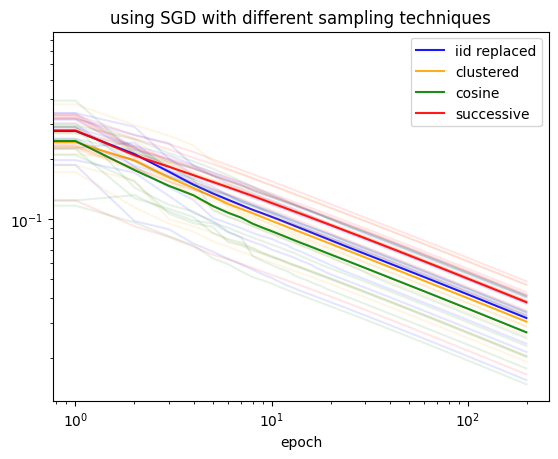

In [32]:
def plot_mult_iter(losses, opt_val, color, label):
    ls = np.array(losses)
    for l in losses:
        plt.plot(l-opt_val, alpha=0.1, color=color)
    m = np.mean(ls, axis=0)
    std = np.std(ls, axis=0)
    l = len(m)
    plt.plot(m-opt_val, color=color, label=label, alpha=0.9)
    # plt.fill_between(np.arange(l), m-opt_val-std, m-opt_val+std, alpha=0.3)

plot_mult_iter(sgd_sols_iid, opt_val, color="blue", label="iid replaced")
plot_mult_iter(sgd_sols_cluster, opt_val, color="orange", label="clustered")
plot_mult_iter(sgd_sols_cosine, opt_val, color="green", label="cosine")
plot_mult_iter(sgd_sols, opt_val, color="red", label="successive")

plt.legend()
# plt.yscale("log")
plt.loglog()
plt.xlabel("epoch")
plt.title("using SGD with different sampling techniques")
plt.show()

In [33]:
from torch import Tensor

def display_grads(dataset:TensorDataset, model, cluster_sampler, alg="pca", title=""):
    dataset_torch, labels = dataset.tensors
    gradients = np.zeros_like(dataset_torch)
    lims = [0]
    for i in range(cluster_sampler.cluster_count):
        selected = dataset_torch[cluster_sampler.clusters[i]]
        selected_labels = labels[cluster_sampler.clusters[i]]
        grad_selected = get_grad(selected, selected_labels, model)
        # print(grad_selected)
        lims.append(lims[-1] + len(cluster_sampler.clusters[i]))
        gradients[lims[-2]:lims[-1], :] = grad_selected
    
    reduced = dimension_reduction(gradients, alg=alg)

    for i in range(cluster_sampler.cluster_count):
        plt.scatter(reduced[lims[i]:lims[i+1],0], reduced[lims[i]:lims[i+1],1], alpha=0.5)
    plt.title(title)
    plt.show()

In [34]:
data, labels = cluster_dataloader.dataset.tensors
full_grad = np.mean(get_grad(data, labels, model), axis=0)
full_grad

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.31690126e-06,
        1.31690126e-06,  1.31690126e-06, -6.19754985e-07, -3.03528935e-07,
        1.00821046e-06,  1.15428088e-06,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  

In [35]:
# checking the variance, see how much it's reduced...
def histogram(dataloader:DataLoader, full_grad=None, label=None):
    res = []

    if full_grad is None:
        data, labels = dataloader.dataset.tensors
        full_grad = np.mean(get_grad(data, labels, model), axis=0)

    print("calculating for {}".format(label))
    for (batch, labels) in dataloader:
        batch_grads = get_grad(batch, labels, model)
        res.append(np.sum((np.mean(batch_grads, axis=0) - full_grad)**2))
    return res[:-1]
    # plt.hist(res, density=True, label=label, alpha=1, histtype="step")
    # return np.array(res)
    
res_iid = histogram(iid_dataloader, full_grad, "iid"),
res_cluster = histogram(cluster_dataloader, full_grad, "cluster"),
res_cos = histogram(cosine_dataloader, full_grad, "cosine"),
res_successive = histogram(DataLoader(dataset, BATCH_SIZE), full_grad, "successive")
# plt.legend()
# plt.show()


calculating for iid
calculating for cluster
calculating for cosine
calculating for successive


0.00285130157135427
0.004938250407576561
0.0029077669605612755
0.0030722981318831444


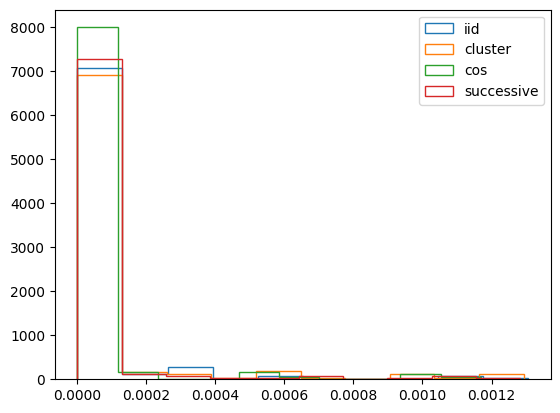

In [36]:
for lab, res in zip(["iid","cluster", "cos", "successive"],
                    [res_iid, res_cluster, res_cos, res_successive]):
    print(np.mean(res)*BATCH_SIZE)
    plt.hist(res, density=True, histtype="step", label=lab)
plt.legend()
plt.show()

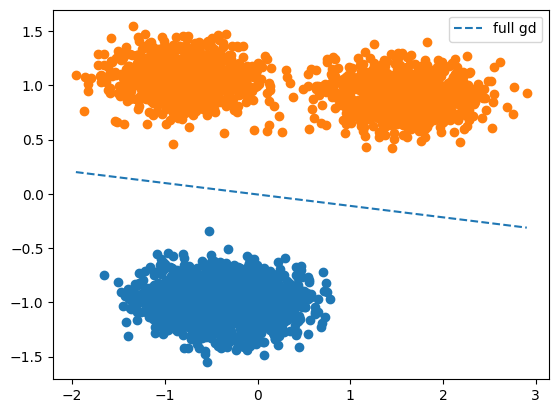

In [42]:
def plot_decision_boundary(data, model, label=None):
    w = model.layer.weight.detach().numpy().flatten()
    b = model.layer.bias.detach().item()
    x_vals = np.linspace(data[:,0].min(), data[:,0].max(), 100)
    if w[1] != 0:
        y_vals = -(w[0] * x_vals + b) / w[1]
        plt.plot(x_vals, y_vals, '--', label=label)
    else:
        # vertical line if w[1] == 0
        x_const = -b / w[0]
        plt.axvline(x_const, linestyle='--', label=label)

plot_decision_boundary(clustered_data, model, "full gd")
# plot_decision_boundary(clustered_data, test_m, "test")

plt.scatter(clustered_data[mask_0, 0], clustered_data[mask_0, 1])
plt.scatter(clustered_data[mask_1, 0], clustered_data[mask_1, 1])
plt.legend()
plt.show()

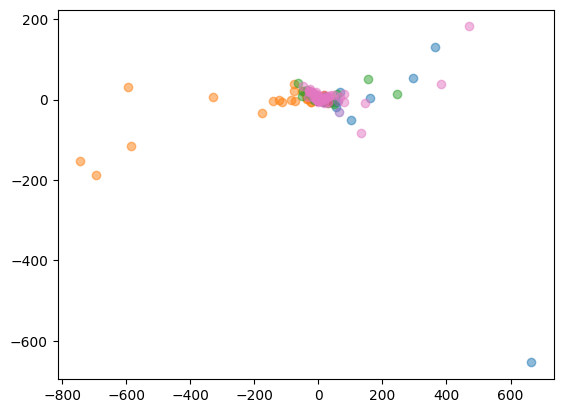

In [37]:
display_grads(dataset, model, cluster_sampler)